## plot the result to inspect

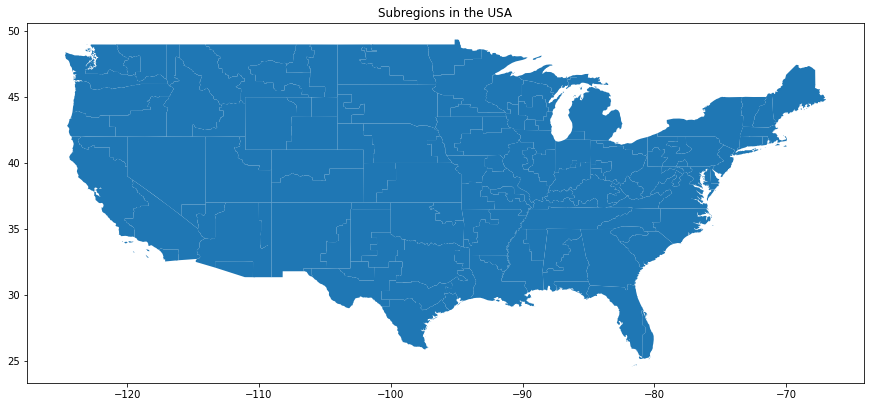

In [8]:
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt 
# Load the polygon data
polygons_gdf = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/US_CAN_MEX_PCA_polygons.csv')

# Filter the GeoDataFrame to keep only the specified 'rb' values
polygons_gdf_filtered = polygons_gdf[polygons_gdf['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Convert WKT to a GeoDataFrame for easier plotting
polygons_gdf_filtered = gpd.GeoDataFrame(polygons_gdf_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_gdf_filtered['WKT']))

# Plotting using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
polygons_gdf_filtered.plot(ax=ax)

# Setting up the plot details
ax.set_title("Subregions in the USA")
plt.show()


In [ ]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import plotly.express as px
import json
import numpy as np
import os
from shapely.geometry import Point
from shapely import wkt
# Process the 'reeds_ba_list' column to expand the sets into individual rows, keeping 'state' intact
from ast import literal_eval
# Get the current directory where your script is running
current_directory = os.getcwd()

# Construct the path to your resources folder dynamically
resources_path = os.path.join(current_directory, 'resources')

# Now, build the full path to your CSV files
polygons_csv_path = os.path.join(resources_path, 'US_CAN_MEX_PCA_polygons.csv')
state_to_ba_csv_path = os.path.join(resources_path, 'state_to_ba_mapping.csv')
# Finally, use pandas to read the CSV files
polygons_df = pd.read_csv(polygons_csv_path)
state_to_ba_df = pd.read_csv(state_to_ba_csv_path)
# Filter polygons
polygons_df = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Since the instructions for processing the state mapping are a bit unclear,
# Convert the string representation of sets in 'reeds_ba_list' to actual sets
state_to_ba_df['reeds_ba_list'] = state_to_ba_df['reeds_ba_list'].apply(literal_eval)

# Explode the sets into separate rows
exploded_df = state_to_ba_df.explode('reeds_ba_list')[['state','reeds_ba_list']]
polygons_df_filtered = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]
polygons_gdf = gpd.GeoDataFrame(polygons_df_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_df_filtered['WKT']))

# Step 2: Merge exploded_df with polygons_gdf on the 'reeds_ba_list' and 'rb' columns
merged_gdf = polygons_gdf.merge(exploded_df, left_on='rb', right_on='reeds_ba_list')
merged_gdf['country']='USA'
merged_gdf=merged_gdf[['rb','state','country','geometry']]

# Country - Group by 'country' and dissolve to merge geometries
gdf_country = merged_gdf.dissolve(by='country').reset_index()

# State - Group by 'state' and dissolve to merge geometries
gdf_state = merged_gdf.dissolve(by='state').reset_index()

# Subregion (rb) - No need to group since each 'rb' is already unique
gdf_subregion = merged_gdf[['rb', 'geometry']].drop_duplicates()


# Convert each GeoDataFrame to GeoJSON for use in Plotly
geojson_country = json.loads(gdf_country.to_json())
geojson_state = json.loads(gdf_state.to_json())
geojson_subregion = json.loads(gdf_subregion.to_json())
import json
current_directory= os.path.join(current_directory, 'web_page_data')
# Define file paths for saving
geojson_country_path = os.path.join(current_directory, 'geojson_country.json')
geojson_state_path = os.path.join(current_directory, 'geojson_state.json')
geojson_subregion_path = os.path.join(current_directory, 'geojson_subregion.json')
# Define file paths for saving
gdf_country_path = os.path.join(current_directory, 'gdf_country.gpkg')
gdf_state_path = os.path.join(current_directory, 'gdf_state.gpkg')
gdf_subregion_path = os.path.join(current_directory, 'gdf_subregion.gpkg')

# Save the GeoDataFrames
gdf_country.to_file(gdf_country_path, driver='GPKG')
gdf_state.to_file(gdf_state_path, driver='GPKG')
gdf_subregion.to_file(gdf_subregion_path, driver='GPKG')

# Function to save GeoJSON to a file
def save_geojson(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f)

# Save the GeoJSON data
save_geojson(geojson_country, geojson_country_path)
save_geojson(geojson_state, geojson_state_path)
save_geojson(geojson_subregion, geojson_subregion_path)


In [ ]:
# Function to read GeoJSON from a file
def read_geojson(file_path):
    with open(file_path) as f:
        return json.load(f)

# Read the GeoJSON data
geojson_country_read = read_geojson(geojson_country_path)
geojson_state_read = read_geojson(geojson_state_path)
geojson_subregion_read = read_geojson(geojson_subregion_path)


In [ ]:
print(geojson_country == geojson_country_read)
print(geojson_state == geojson_state_read)
print(geojson_subregion == geojson_subregion_read)


In [ ]:
# Read the GeoDataFrames
gdf_country_read = gpd.read_file(gdf_country_path)
gdf_state_read = gpd.read_file(gdf_state_path)
gdf_subregion_read = gpd.read_file(gdf_subregion_path)


In [ ]:
print(gdf_country.shape == gdf_country_read.shape)
print(gdf_state.shape == gdf_state_read.shape)
print(gdf_subregion.shape == gdf_subregion_read.shape)

# Sample a row and compare geometries (example using 'gdf_country')
print(gdf_country.geometry.iloc[0].equals(gdf_country_read.geometry.iloc[0]))


In [ ]:
# Define paths for the GeoJSON files
country_geojson_path = os.path.join(data_path, 'country_centroids.csv')
state_geojson_path = os.path.join(data_path, 'state_centroids.csv')
rb_geojson_path = os.path.join(data_path, 'rb_centroids.csv')



# Convert the DataFrames to GeoDataFrames
gdf_country_centroids = df_to_gdf(country_centroids_df)
gdf_state_centroids = df_to_gdf(state_centroids_df)
gdf_rb_centroids = df_to_gdf(rb_centroids_df)
gdf_country_centroids 

In [3]:
# Assuming you have a GeoJSON file and a corresponding GeoDataFrame
import geopandas as gpd
import json
import os
current_directory = os.getcwd()
data_path = os.path.join(current_directory, 'web_page_data')

geojson_country_path = os.path.join(data_path, 'geojson_country.json')
geojson_state_path = os.path.join(data_path, 'geojson_state.json')
geojson_subregion_path = os.path.join(data_path, 'geojson_subregion.json')

# Define file paths for saving
gdf_country_path = os.path.join(data_path, 'gdf_country.gpkg')
gdf_state_path = os.path.join(data_path, 'gdf_state.gpkg')
gdf_subregion_path = os.path.join(data_path, 'gdf_subregion.gpkg')

# Load GeoJSON
with open(geojson_country_path) as f:
    geojson_country = json.load(f)
with open(geojson_state_path) as f:
    geojson_state = json.load(f)
with open(geojson_subregion_path) as f:
    geojson_subregion = json.load(f)

# Check the first GeoJSON feature properties
print("GeoJSON feature example:", geojson_subregion['features'][0]['properties'])

# Load GeoDataFrame and check its first row
gdf_subregion = gpd.read_file(gdf_subregion_path)
print("GeoDataFrame example:", gdf_subregion.iloc[0])

# Ensure the 'locations' parameter in Plotly Express matches these identifiers


GeoJSON feature example: {'rb': 'p1'}
GeoDataFrame example: rb                                                         p1
geometry    MULTIPOLYGON (((-122.960715524824 47.144493305...
Name: 0, dtype: object


In [5]:
# For GeoJSON - Collecting all 'rb' values
rb_values_geojson = [feature['properties']['rb'] for feature in geojson_subregion['features']]
print(rb_values_geojson)

# For GeoDataFrame - Assuming 'rb' is a column in the gdf_subregion
rb_values_gdf = gdf_subregion['rb'].tolist()
print(rb_values_gdf)

# Check if both lists are equal - This helps to quickly identify if there's a perfect match
if rb_values_geojson == rb_values_gdf:
    print("The 'rb' values in both GeoJSON and GeoDataFrame match perfectly.")
else:
    print("There is a discrepancy in the 'rb' values between GeoJSON and GeoDataFrame.")


['p1', 'p10', 'p100', 'p101', 'p102', 'p103', 'p104', 'p105', 'p106', 'p107', 'p108', 'p109', 'p11', 'p110', 'p111', 'p112', 'p113', 'p114', 'p115', 'p116', 'p117', 'p118', 'p119', 'p12', 'p120', 'p121', 'p122', 'p123', 'p124', 'p125', 'p126', 'p127', 'p128', 'p129', 'p13', 'p130', 'p131', 'p132', 'p133', 'p134', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p2', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p3', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p4', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p5', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p6', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p7', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p8', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p9', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99']
['p1', 'p10', 'p100', 'p101', 'p102

In [9]:
import folium

def create_map_from_multipolygons(gdf):
    # Initialize the map with a central location and zoom level suitable for your data
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Iterate over GeoDataFrame to add each MULTIPOLYGON to the map
    for _, row in gdf.iterrows():
        # Folium requires geometries to be in GeoJSON format
        geo_json = folium.GeoJson(data=row['geometry'].__geo_interface__, tooltip=f"rb: {row['rb']}")
        geo_json.add_to(m)

    return m

# Assuming gdf_subregion is your GeoDataFrame containing MULTIPOLYGON geometries and 'rb' values
map_multipolygons = create_map_from_multipolygons(gdf_subregion.to_crs(epsg=4326))
map_multipolygons


In [13]:
# Assuming gdf_subregion is your GeoDataFrame containing MULTIPOLYGON geometries and 'rb' values
# Load GeoDataFrame and check its first row
def create_map_from_multipolygons(gdf):
    # Initialize the map with a central location and zoom level suitable for your data
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Iterate over GeoDataFrame to add each MULTIPOLYGON to the map
    for _, row in gdf.iterrows():
        # Folium requires geometries to be in GeoJSON format
        geo_json = folium.GeoJson(data=row['geometry'].__geo_interface__, tooltip=f"state: {row['state']}")
        geo_json.add_to(m)

    return m
gdf_state = gpd.read_file(gdf_state_path)
map_multipolygons = create_map_from_multipolygons(gdf_state.to_crs(epsg=4326))
map_multipolygons

In [7]:

import pandas as pd
import os
from datetime import datetime

# Define the directory where the CSV files are located
directory = '/Volumes/T7/prediction/rcp85hotter'

# Create a list of all 'rb' codes and years
rb_codes = [f'p{i}' for i in range(1, 135)]



# Function to read and process files for a given rb code
def process_rb_files(rb_code):
    rb_df_list = []
    # Loop through all years for the given rb_code
    for year in years:
        # Construct file name
        folder_path = os.path.join(directory, str(year))
        file_name = f"{rb_code}_{year}_mlp_output.csv"
        file_path = os.path.join(folder_path, file_name)
        # Check if file exists to avoid FileNotFoundError
        if os.path.isfile(file_path):
            # Read the CSV file
            temp_df = pd.read_csv(file_path)
            temp_df=temp_df[['Time_UTC','Load']]
            # Convert 'Time_UTC' to datetime and extract 'Year' and 'Month'
            temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
            temp_df['Year'] = temp_df['Time_UTC'].dt.year
            temp_df['Month'] = temp_df['Time_UTC'].dt.month
            # Aggregate Load by 'Year' and 'Month'
            aggregated_df = temp_df.groupby(['Year', 'Month'])['Load'].sum().reset_index()
            # Add the aggregated data to the list
            rb_df_list.append(aggregated_df)
    
    # Vertically concatenate all yearly data for the rb code
    concatenated_df = pd.concat(rb_df_list, ignore_index=True)
    return concatenated_df

years = list(range(2020, 2100))
months = list(range(1, 13))

# Create a DataFrame with all combinations of 'Year' and 'Month'
year_month_df = pd.DataFrame([(y, m) for y in years for m in months], columns=['Year', 'Month'])

# Placeholder to simulate merging data for multiple rb codes
final_df = year_month_df.copy()
for rb_code in rb_codes: 
    rb_df = process_rb_files(rb_code)
    final_df = final_df.merge(rb_df, on=['Year', 'Month'], how='left').rename(columns={'Load': rb_code})
# Placeholder function to read 'state_to_ba_mapping.csv' and perform aggregation
def string_to_set(string):
    # Remove curly braces and split the string
    elements = string.replace('{', '').replace('}', '').split(',')
    # Remove any extra whitespace and single quotes from each element
    elements = [e.strip().replace("'", "") for e in elements]
    return set(elements)
def aggregate_state_data(final_df):
    # Placeholder to simulate reading the 'state_to_ba_mapping.csv' file
    # In practice, this should read the actual file
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')

    # Add columns for each state by summing the relevant rb columns based on the mapping
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])
        state_column = row['state']
        # Sum the columns specified in reeds_ba_list for each state
        final_df[state_column] = final_df[list(rb_list)].sum(axis=1)

    # Calculate the total for the USA by summing all state columns
    state_columns = state_to_ba_mapping['state'].values
    final_df['USA'] = final_df[state_columns].sum(axis=1)

    return final_df

# Apply the placeholder aggregation function to the simulated final_df
final_aggregated_df = aggregate_state_data(final_df)

def aggregate_state_data(final_df):
    # Placeholder to simulate reading the 'state_to_ba_mapping.csv' file
    # In practice, this should read the actual file
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')

    # Add columns for each state by summing the relevant rb columns based on the mapping
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])
        state_column = row['state']
        # Sum the columns specified in reeds_ba_list for each state
        final_df[state_column] = final_df[list(rb_list)].sum(axis=1)

    # Calculate the total for the USA by summing all state columns
    state_columns = state_to_ba_mapping['state'].values
    final_df['USA'] = final_df[state_columns].sum(axis=1)

    return final_df

# Apply the placeholder aggregation function to the simulated final_df
final_aggregated_df = aggregate_state_data(final_df)
final_aggregated_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp85hotter.csv')

,Year,Month,p1,p2,p3,p4,p5,p6,p7,p8,...,p125,p126,p127,p128,p129,p130,p131,p132,p133,p134
0,2020,1,4881434.49,2709178.05,1172293.24,469885.50,3455648.85,999613.47,111631.81,105293.42,...,992860.67,6732928.43,10596254.96,1668765.88,509564.08,979525.69,5004420.11,2663210.84,670300.79,1049849.61
1,2020,2,3982555.36,2230732.61,968739.72,378902.32,2872783.58,851139.72,92514.02,91572.16,...,918117.52,6201880.93,9902995.62,1539248.76,465976.85,893047.35,4625627.18,2463105.66,618649.10,968063.66
2,2020,3,4158896.86,2262245.10,976282.80,360545.01,2954707.13,875605.76,95360.82,96716.90,...,911798.89,6156083.07,10002647.11,1549894.51,463682.48,895382.75,4666499.26,2453789.60,626542.89,984501.14
3,2020,4,3696850.52,2025303.70,874399.84,335524.08,2622763.86,772550.76,89160.21,99230.57,...,808405.78,5510022.45,9058085.83,1411257.59,417772.26,812336.46,4210058.55,2195676.45,567903.89,880475.23
4,2020,5,3644918.65,2086502.95,882270.49,379453.74,2657710.48,795818.01,97577.59,106203.94,...,900114.30,6194714.60,9715823.90,1599232.45,428699.62,841350.69,4387208.64,2364179.84,599892.54,884754.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2099,8,3828678.73,2411529.83,1195979.07,506882.68,3302400.65,1001354.83,183583.80,151491.07,...,1457278.90,9981196.46,15190958.25,2929534.45,582908.31,1229199.53,7084732.10,3787087.17,1016595.45,1143859.06
956,2099,9,3516697.89,2172535.69,1042566.89,422114.37,2972310.00,911856.82,145427.39,135205.77,...,1236869.96,8294728.92,12823759.73,2374855.07,504545.04,1039510.93,5865460.65,3107102.07,822688.42,1012616.21
957,2099,10,3576199.41,2018614.21,926150.86,347686.31,2711412.65,818755.41,95995.45,114753.41,...,989115.69,6754390.02,10913276.22,1845079.15,462678.37,909611.16,4922122.10,2581775.85,668716.61,961415.46
958,2099,11,3683428.64,1971334.53,894561.12,317885.92,2646858.61,791620.66,79812.84,107827.95,...,838165.89,5750945.23,9351853.80,1487301.36,439037.48,839280.63,4361368.66,2281242.66,592943.11,928454.19


In [23]:

import pandas as pd
import os
from datetime import datetime
import numpy as np
# Placeholder function to read 'state_to_ba_mapping.csv' and perform aggregation
def string_to_set(string):
    # Remove curly braces and split the string
    elements = string.replace('{', '').replace('}', '').split(',')
    # Remove any extra whitespace and single quotes from each element
    elements = [e.strip().replace("'", "") for e in elements]
    return set(elements)
# Define the directory where the CSV files are located
directory = '/Volumes/T7/prediction/rcp85hotter'

# Create a list of all 'rb' codes and years
rb_codes = [f'p{i}' for i in range(1, 135)]
years = list(range(2020, 2100))
months = list(range(1, 13))


def process_rb_files_daily(rb_code, years):
    rb_df_list = []
    for year in years:
        folder_path = os.path.join(directory, str(year))
        file_name = f"{rb_code}_{year}_mlp_output.csv"
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            temp_df = pd.read_csv(file_path)[['Time_UTC', 'Load']]
            temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
            rb_df_list.append(temp_df)
    concatenated_df = pd.concat(rb_df_list, ignore_index=True)
    return concatenated_df
def aggregate_state_and_usa_daily(final_rb_df):
    # Read the state to rb mapping
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    
    # For each state, sum the relevant 'rb' daily sums
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])  # Convert string to list/set of rb codes
        state_column = row['state']
        # Ensure only existing columns are summed
        rb_columns = [rb for rb in rb_list if rb in final_rb_df.columns]
        # Summing for each state
        final_rb_df[state_column] = final_rb_df[rb_columns].sum(axis=1)
    
    # Summing all states to get USA total
    state_columns = state_to_ba_mapping['state'].tolist()
    final_rb_df['USA'] = final_rb_df[state_columns].sum(axis=1)
    
    return final_rb_df



final_dfs = []
for year in years:
    # Process data for the year (pseudo-code placeholders for actual processing)
    First=True
    for rb_code in rb_codes:
        temp_df = process_rb_files_daily(rb_code, [year])
        if First:
            processed_df=temp_df.copy()
            First=False
            processed_df[rb_code]=processed_df['Load']
            processed_df=processed_df.drop(['Load'], axis=1)
        else:
            # Assuming processed_df and temp_df are defined and have the appropriate columns
            processed_df = processed_df.merge(temp_df, on=['Time_UTC'], how='inner')
            processed_df[rb_code]=processed_df['Load']
            processed_df=processed_df.drop(['Load'], axis=1)
    processed_df = aggregate_state_and_usa_daily(processed_df)
    processed_df['Time_UTC'] = pd.to_datetime(processed_df['Time_UTC'])
    processed_df['Year'] = processed_df['Time_UTC'].dt.year
    processed_df['Month'] = processed_df['Time_UTC'].dt.month


    processed_df=processed_df.drop(['Time_UTC'], axis=1)
    # Group by 'weekday' and 'Year', then apply the aggregations
    # Define aggregations to apply 'max' to all columns except 'Year', 'Month', and 'weekday'
    aggregations = {col: 'max' for col in processed_df.columns if col not in ['Year', 'Month']}

    # Group by 'Year' and 'Month', then aggregate
    grouped_df = processed_df.groupby(['Year', 'Month']).agg(aggregations)



    # Reset index to turn 'Year' and 'Month' back into columns if needed
    grouped_df.reset_index(inplace=True)
    final_dfs.append(grouped_df)


    

final_df = pd.concat(final_dfs, axis=0, ignore_index=True)
final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/max_rcp85hotter_monthlly.csv')
final_df

,Year,Month,p1,p2,p3,p4,p5,p6,p7,p8,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,USA
0,2020,1,8593.76,4768.27,2015.04,827.12,6098.34,1660.11,186.71,167.48,...,17478.30,50278.21,3825.31,871.68,18271.38,16189.28,4966.35,9714.91,2553.84,548494.83
1,2020,2,7855.52,4053.18,1905.34,710.61,5553.76,1404.10,159.31,149.05,...,16647.71,49032.22,3656.48,826.63,18605.80,14485.42,5035.50,9265.95,2291.10,517428.05
2,2020,3,6941.86,3818.25,1673.10,611.22,4851.91,1387.51,157.76,151.25,...,19222.05,48562.64,3532.85,776.71,18434.40,12917.25,5212.31,8858.38,2173.26,534075.58
3,2020,4,6364.74,3464.47,1524.32,554.13,4480.24,1280.64,154.25,160.52,...,13544.11,46554.89,3429.43,695.74,13763.85,11849.60,4137.10,8644.86,1943.45,452187.70
4,2020,5,5695.19,3287.86,1484.42,614.05,4548.23,1381.70,182.92,178.49,...,15093.38,58534.67,3909.04,738.51,17929.25,10964.56,4473.68,10028.69,2037.20,544601.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2099,8,6455.14,4046.78,2170.27,831.32,5880.01,1690.35,312.15,256.57,...,20323.38,73595.73,4880.20,1158.18,24166.21,13417.86,6040.02,13144.60,2665.49,752393.17
956,2099,9,6319.24,3988.09,2058.65,764.48,5797.79,1660.52,284.31,247.00,...,20073.84,71664.01,4826.91,1021.31,23055.91,13096.67,5610.23,12043.75,2565.98,726286.45
957,2099,10,6267.96,3344.90,1519.80,573.01,4674.22,1449.56,185.04,207.81,...,19862.76,66056.56,3958.91,906.53,20812.12,11577.80,5489.58,10564.23,2115.55,651022.89
958,2099,11,6812.12,3590.26,1590.05,575.59,4669.23,1370.34,150.65,188.31,...,13817.37,50452.26,3547.01,785.35,14783.06,12348.23,4214.99,8885.81,2097.68,488971.87


In [ ]:
# Step 1: Modify process_rb_files function for daily aggregation

# Step 2: For each state and the USA, calculate daily sums

# Step 3: Calculate statistics (mean, 5% lower quantile, 95% upper quantile)
#         Separate calculations for weekdays and weekends

# Step 4: Store results with specified column names

# Step 5: Add 'Year Record' column

# Step 6: Vertically concatenate data for all years


In [21]:

import pandas as pd
import os
from datetime import datetime
import numpy as np

# Define the directory where the CSV files are located
directory = '/Volumes/T7/prediction/rcp85hotter'

# Create a list of all 'rb' codes and years
rb_codes = [f'p{i}' for i in range(1, 135)]
years = list(range(2020, 2100))
months = list(range(1, 13))


def process_rb_files_daily(rb_code, years):
    rb_df_list = []
    for year in years:
        folder_path = os.path.join(directory, str(year))
        file_name = f"{rb_code}_{year}_mlp_output.csv"
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            temp_df = pd.read_csv(file_path)[['Time_UTC', 'Load']]
            temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
            # Additional grouping by day
            temp_df['Day'] = temp_df['Time_UTC'].dt.day
            temp_df['Year'] = temp_df['Time_UTC'].dt.year
            temp_df['Month'] = temp_df['Time_UTC'].dt.month
            aggregated_df = temp_df.groupby(['Year', 'Month', 'Day'])['Load'].sum().reset_index()
            rb_df_list.append(aggregated_df)
    concatenated_df = pd.concat(rb_df_list, ignore_index=True)
    return concatenated_df
def aggregate_state_and_usa_daily(final_rb_df):
    # Read the state to rb mapping
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    
    # For each state, sum the relevant 'rb' daily sums
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])  # Convert string to list/set of rb codes
        state_column = row['state']
        # Ensure only existing columns are summed
        rb_columns = [rb for rb in rb_list if rb in final_rb_df.columns]
        # Summing for each state
        final_rb_df[state_column] = final_rb_df[rb_columns].sum(axis=1)
    
    # Summing all states to get USA total
    state_columns = state_to_ba_mapping['state'].tolist()
    final_rb_df['USA'] = final_rb_df[state_columns].sum(axis=1)
    
    return final_rb_df

def upper_95(x):
    return x.quantile(0.95)

def lower_5(x):
    return x.quantile(0.05)
# Define a function to reorganize each column into an array grouped by Year
def reorganize_into_array(series):
    # Pre-fill the array with NaNs to handle missing weekdays
    array = [np.nan] * 7  # One entry for each day of the week
    for idx, value in series.items():
        # idx is a tuple (Year, weekday), value is the column value
        # Subtract 1 from idx[1] if weekday starts from 1 in your dataset
        array[idx[1]] = value  # Or idx[1] - 1 if weekday is 1-based
    return array

final_dfs = []
for year in years:
    # Process data for the year (pseudo-code placeholders for actual processing)
    First=True
    for rb_code in rb_codes:
        temp_df = process_rb_files_daily(rb_code, [year])
        if First:
            processed_df=temp_df.copy()
            First=False
            processed_df[rb_code]=processed_df['Load']
            processed_df=processed_df.drop(['Load'], axis=1)
        else:
            # Assuming processed_df and temp_df are defined and have the appropriate columns
            processed_df = processed_df.merge(temp_df, on=['Year', 'Month', 'Day'], how='inner')
            processed_df[rb_code]=processed_df['Load']
            processed_df=processed_df.drop(['Load'], axis=1)
    processed_df = aggregate_state_and_usa_daily(processed_df)
    processed_df['Date'] = pd.to_datetime(processed_df[['Year', 'Month', 'Day']])

    # Create the 'weekday' column, note that dt.dayofweek returns Monday=0 through Sunday=6, so we add 1
    processed_df['weekday'] = processed_df['Date'].dt.dayofweek 
    processed_df=processed_df.drop(['Month','Day','Date'], axis=1)
    # Group by 'weekday' and 'Year', then apply the aggregations
    aggregations = {col: ['mean','max', upper_95, lower_5] for col in processed_df.columns if col not in ['Year', 'weekday']}
    grouped_df = processed_df.groupby(['Year', 'weekday']).agg(aggregations)
    # Now, flatten the MultiIndex in columns created by aggregation
    grouped_df.columns = ['{}_{}'.format(col[0], col[1]) for col in grouped_df.columns]

    # To further match your requirement, rename the aggregation methods in column names
    grouped_df.rename(columns=lambda x: x.replace('mean', 'mean').replace('upper_95', 'upper').replace('lower_5', 'lower'), inplace=True)

    # Reset index to turn 'Year' and 'weekday' back into columns if needed
    grouped_df= grouped_df.reset_index()
    # First, let's ensure 'weekday' is in the correct data type if not already
    grouped_df['weekday'] = grouped_df['weekday'].astype(int)
    final_dfs.append(grouped_df)
    

final_df = pd.concat(final_dfs, axis=0, ignore_index=True)
final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp85hotter_weekly.csv')
            



In [20]:

import pandas as pd
import os
from datetime import datetime
import numpy as np

# Define the directory where the CSV files are located
directory = '/Volumes/T7/prediction/rcp85hotter'

# Create a list of all 'rb' codes and years
rb_codes = [f'p{i}' for i in range(1, 135)]
years = list(range(2020, 2100))
months = list(range(1, 13))

def aggregate_state_and_usa_daily(final_rb_df):
    # Read the state to rb mapping
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    
    # For each state, sum the relevant 'rb' daily sums
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])  # Convert string to list/set of rb codes
        state_column = row['state']
        # Ensure only existing columns are summed
        rb_columns = [rb for rb in rb_list if rb in final_rb_df.columns]
        # Summing for each state
        final_rb_df[state_column] = final_rb_df[rb_columns].sum(axis=1)
    
    # Summing all states to get USA total
    state_columns = state_to_ba_mapping['state'].tolist()
    final_rb_df['USA'] = final_rb_df[state_columns].sum(axis=1)
    return final_rb_df

def process_rb_files_hourly(rb_code, years):
    rb_df_list = []
    for year in years:
        folder_path = os.path.join(directory, str(year))
        file_name = f"{rb_code}_{year}_mlp_output.csv"
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            temp_df = pd.read_csv(file_path)[['Time_UTC', 'Load']]
            temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
            # Additional grouping by day
            # Add an 'Hour' column by extracting the hour from 'Time_UTC'
            temp_df['Hour'] = temp_df['Time_UTC'].dt.hour
            temp_df['Year'] = temp_df['Time_UTC'].dt.year
            # Use dt.dayofweek to determine the day of the week; then use np.where to classify as 'Weekday' or 'Weekend'
            temp_df['Weekend_or_Weekday'] = np.where(temp_df['Time_UTC'].dt.dayofweek < 5, 'Weekday', 'Weekend')
            temp_df[rb_code]=temp_df['Load']
            # Dropping the 'Time_UTC' and 'Load' columns from temp_df
            temp_df = temp_df.drop(columns=['Time_UTC', 'Load'])
        
            aggregations = {rb_code: ['mean','max', upper_95, lower_5]}
            # Group by 'Hour', 'Year', 'Weekend_or_Weekday', then aggregate
            temp_df = temp_df.groupby(['Hour', 'Year', 'Weekend_or_Weekday']).agg(aggregations)

            # Flatten the MultiIndex columns if you have multiple columns being aggregated
            temp_df.columns = ['_'.join(col).strip() for col in temp_df.columns.values]

            # Reset index if you want 'Hour', 'Year', 'Weekend_or_Weekday' back as regular columns
            temp_df.reset_index(inplace=True)


            rb_df_list.append(temp_df)
    concatenated_df = pd.concat(rb_df_list, ignore_index=True)
    return concatenated_df


def upper_95(x):
    return x.quantile(0.95)

def lower_5(x):
    return x.quantile(0.05)
# Define a function to reorganize each column into an array grouped by Year


final_dfs = []
for year in years:#years
    # Process data for the year (pseudo-code placeholders for actual processing)
    First=True
    for rb_code in rb_codes:
        temp_df = process_rb_files_hourly(rb_code, [year])
        if First:
            processed_df=temp_df.copy()
            First=False
        else:
            processed_df = processed_df.merge(temp_df, on=['Hour','Year','Weekend_or_Weekday'], how='inner')
    processed_df.rename(columns=lambda x: x.replace('mean', 'mean').replace('upper_95', 'upper').replace('lower_5', 'lower'), inplace=True)
    final_dfs.append(processed_df)

final_df = pd.concat(final_dfs, axis=0, ignore_index=True)
final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp85hotter_daily.csv')
final_df


,Hour,Year,Weekend_or_Weekday,p1_mean,p1_max,p1_upper,p1_lower,p2_mean,p2_max,p2_upper,...,p132_upper,p132_lower,p133_mean,p133_max,p133_upper,p133_lower,p134_mean,p134_max,p134_upper,p134_lower
0,0,2020,Weekday,4238.348008,6770.62,5313.5700,3643.1500,2518.966130,3842.49,3059.3100,...,3733.5000,2391.4100,735.462222,1176.37,993.3900,615.6300,1054.773487,1282.11,1206.4000,941.8400
1,0,2020,Weekend,4280.473846,6186.00,5683.8360,3634.7835,2513.367019,3369.01,3166.3810,...,3593.9380,2324.9545,739.727692,1057.87,964.1220,614.4750,1066.063558,1376.08,1218.1180,948.9300
2,1,2020,Weekday,4152.031450,6419.22,5212.4145,3534.2665,2481.426870,3751.33,2986.6555,...,3514.1255,2304.1750,707.520992,1127.84,949.4140,592.2985,1041.024618,1285.58,1191.2440,928.1630
3,1,2020,Weekend,4133.068173,6036.43,5456.3625,3493.4390,2469.297885,3368.39,3144.6140,...,3378.9935,2180.7460,694.607885,997.00,908.3255,574.1120,1030.853558,1337.85,1185.3515,913.0945
4,2,2020,Weekday,4102.692443,6543.10,5168.4605,3444.1075,2479.810038,3847.36,3092.6315,...,3364.4880,2223.2970,681.786298,1077.35,913.3535,570.4245,1027.127863,1286.07,1180.3775,912.6060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,21,2099,Weekend,5301.054615,6091.90,5893.6025,4684.8790,2995.908750,3600.60,3520.2420,...,5681.2010,3142.0990,1005.196538,1661.88,1498.4630,799.6850,1342.073462,1713.82,1633.0725,1188.7115
3836,22,2099,Weekday,5192.472031,6225.51,5846.9900,4531.7200,2971.529387,3625.82,3461.4100,...,5734.2500,3032.0900,995.659310,1864.86,1536.7800,781.2100,1322.102031,1886.69,1616.5600,1158.9000
3837,22,2099,Weekend,5007.599038,5707.44,5578.8360,4459.7845,2838.754712,3432.05,3367.3485,...,5411.5680,2894.1125,936.667212,1603.65,1403.9320,751.5990,1263.635865,1650.32,1537.0220,1117.1525
3838,23,2099,Weekday,4813.678046,5738.78,5366.1800,4174.3000,2787.655019,3470.67,3270.3300,...,5292.3800,2598.3900,903.352261,1687.57,1414.4600,670.9300,1223.931839,1741.21,1454.0800,1057.4200


In [17]:

import pandas as pd
import os
from datetime import datetime
import numpy as np

# Define the directory where the CSV files are located
directory = '/Volumes/T7/prediction/rcp85hotter'

# Create a list of all 'rb' codes and years
rb_codes = [f'p{i}' for i in range(1, 135)]
years = list(range(2020, 2100))
months = list(range(1, 13))

def aggregate_state_and_usa_daily(final_rb_df):
    # Read the state to rb mapping
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    
    # For each state, sum the relevant 'rb' daily sums
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])  # Convert string to list/set of rb codes
        state_column = row['state']
        # Ensure only existing columns are summed
        rb_columns = [rb for rb in rb_list if rb in final_rb_df.columns]
        # Summing for each state
        final_rb_df[state_column] = final_rb_df[rb_columns].sum(axis=1)
    
    # Summing all states to get USA total
    state_columns = state_to_ba_mapping['state'].tolist()
    final_rb_df['USA'] = final_rb_df[state_columns].sum(axis=1)
    return final_rb_df

def process_rb_files_hourly(rb_code, years):
    rb_df_list = []
    for year in years:
        folder_path = os.path.join(directory, str(year))
        file_name = f"{rb_code}_{year}_mlp_output.csv"
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            temp_df = pd.read_csv(file_path)[['Time_UTC', 'Load']]
            temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
            # Additional grouping by day
            # Add an 'Hour' column by extracting the hour from 'Time_UTC'
            temp_df['Hour'] = temp_df['Time_UTC'].dt.hour
            temp_df['Year'] = temp_df['Time_UTC'].dt.year
            # Use dt.dayofweek to determine the day of the week; then use np.where to classify as 'Weekday' or 'Weekend'
            temp_df['Weekend_or_Weekday'] = np.where(temp_df['Time_UTC'].dt.dayofweek < 5, 'Weekday', 'Weekend')
            temp_df[rb_code]=temp_df['Load']
            # Dropping the 'Time_UTC' and 'Load' columns from temp_df
            temp_df = temp_df.drop(columns=['Time_UTC', 'Load'])
        
            # Update the aggregations dictionary to include 'max' for the rb_code column
            aggregations = {rb_code: ['mean', 'max', upper_95, lower_5]}
            # Group by 'Hour', 'Year', 'Weekend_or_Weekday', then aggregate
            temp_df = temp_df.groupby(['Hour', 'Year', 'Weekend_or_Weekday']).agg(aggregations)

            # Flatten the MultiIndex columns if you have multiple columns being aggregated
            temp_df.columns = ['_'.join(col).strip() for col in temp_df.columns.values]

            # Reset index if you want 'Hour', 'Year', 'Weekend_or_Weekday' back as regular columns
            temp_df.reset_index(inplace=True)


            rb_df_list.append(temp_df)
    concatenated_df = pd.concat(rb_df_list, ignore_index=True)
    return concatenated_df


def upper_95(x):
    return x.quantile(0.95)

def lower_5(x):
    return x.quantile(0.05)
# Define a function to reorganize each column into an array grouped by Year


final_dfs = []
for year in [2020]:#years
    # Process data for the year (pseudo-code placeholders for actual processing)
    First=True
    for rb_code in rb_codes:
        temp_df = process_rb_files_hourly(rb_code, [year])
        if First:
            processed_df=temp_df.copy()
            First=False
        else:
            processed_df = processed_df.merge(temp_df, on=['Hour','Year','Weekend_or_Weekday'], how='inner')
    processed_df.rename(columns=lambda x: x.replace('mean', 'mean').replace('upper_95', 'upper').replace('lower_5', 'lower'), inplace=True)
    final_dfs.append(processed_df)

final_df = pd.concat(final_dfs, axis=0, ignore_index=True)
final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp85hotter_daily_max.csv')
final_df

,Hour,Year,Weekend_or_Weekday,p1_mean,p1_max,p1_upper,p1_lower,p2_mean,p2_max,p2_upper,...,p132_upper,p132_lower,p133_mean,p133_max,p133_upper,p133_lower,p134_mean,p134_max,p134_upper,p134_lower
0,0,2020,Weekday,4238.348008,6770.62,5313.5700,3643.1500,2518.966130,3842.49,3059.3100,...,3733.5000,2391.4100,735.462222,1176.37,993.3900,615.6300,1054.773487,1282.11,1206.4000,941.8400
1,0,2020,Weekend,4280.473846,6186.00,5683.8360,3634.7835,2513.367019,3369.01,3166.3810,...,3593.9380,2324.9545,739.727692,1057.87,964.1220,614.4750,1066.063558,1376.08,1218.1180,948.9300
2,1,2020,Weekday,4152.031450,6419.22,5212.4145,3534.2665,2481.426870,3751.33,2986.6555,...,3514.1255,2304.1750,707.520992,1127.84,949.4140,592.2985,1041.024618,1285.58,1191.2440,928.1630
3,1,2020,Weekend,4133.068173,6036.43,5456.3625,3493.4390,2469.297885,3368.39,3144.6140,...,3378.9935,2180.7460,694.607885,997.00,908.3255,574.1120,1030.853558,1337.85,1185.3515,913.0945
4,2,2020,Weekday,4102.692443,6543.10,5168.4605,3444.1075,2479.810038,3847.36,3092.6315,...,3364.4880,2223.2970,681.786298,1077.35,913.3535,570.4245,1027.127863,1286.07,1180.3775,912.6060
5,2,2020,Weekend,4103.831058,5933.30,5353.7125,3425.3780,2438.183942,3345.04,3167.7000,...,3285.1365,2112.4145,677.182885,978.40,888.0080,563.2010,1019.262404,1304.71,1177.5140,904.5240
6,3,2020,Weekday,4219.914466,6616.96,5252.0365,3586.5715,2511.282176,3965.72,3184.3075,...,3272.4215,2194.4935,679.182977,1057.52,902.5250,568.5195,1048.365382,1297.46,1197.4755,936.1055
7,3,2020,Weekend,4105.776442,5885.38,5424.3730,3396.0080,2418.531346,3351.98,3162.0935,...,3226.5440,2088.4820,660.053173,960.04,863.8390,549.9780,1027.371346,1312.09,1192.4765,916.3825
8,4,2020,Weekday,4552.287557,7144.67,5645.7535,3822.6575,2674.681832,4277.96,3441.5555,...,3344.6970,2256.1195,694.544924,1053.60,905.4930,588.1585,1102.307901,1402.83,1288.3695,982.1705
9,4,2020,Weekend,4195.547692,6007.24,5575.3190,3470.8085,2464.554712,3473.32,3266.0870,...,3200.2225,2076.9135,660.471538,968.03,853.0090,551.0795,1034.248942,1323.93,1200.0440,924.5275


In [22]:
import pandas as pd
import numpy as np
import os

# Define the directory where the CSV files are located and other initial setups
directory = '/Volumes/T7/prediction/rcp85hotter'
rb_codes = [f'p{i}' for i in range(1, 135)]
years = list(range(2020, 2100))

def string_to_set(string):
    elements = string.replace('{', '').replace('}', '').split(',')
    return set(e.strip().replace("'", "") for e in elements)

def upper_95(x):
    return x.quantile(0.95)

def lower_5(x):
    return x.quantile(0.05)

def process_rb_files_hourly(rb_code, year):
    file_name = f"{rb_code}_{year}_mlp_output.csv"
    file_path = os.path.join(directory, str(year), file_name)
    if os.path.isfile(file_path):
        temp_df = pd.read_csv(file_path, usecols=['Time_UTC', 'Load'])
        temp_df['Time_UTC'] = pd.to_datetime(temp_df['Time_UTC'])
        temp_df[rb_code]=temp_df['Load']
        # temp_df['Hour'] = temp_df['Time_UTC'].dt.hour
        # temp_df['Year'] = temp_df['Time_UTC'].dt.year
        # temp_df['Weekend_or_Weekday'] = np.where(temp_df['Time_UTC'].dt.dayofweek < 5, 'Weekday', 'Weekend')
        # temp_df['Day'] = temp_df['Time_UTC'].dt.day
        # temp_df['Month'] = temp_df['Time_UTC'].dt.month
        temp_df.drop(columns=['Load'], inplace=True)
        return temp_df
    else:
        return pd.DataFrame()

def aggregate_state_and_usa_daily(df, state_to_ba_mapping):
    for index, row in state_to_ba_mapping.iterrows():
        rb_list = string_to_set(row['reeds_ba_list'])
        state_column = row['state']
        df[state_column] = df[[col for col in df.columns if col in rb_list]].sum(axis=1)
    df['USA'] = df[[row['state'] for index, row in state_to_ba_mapping.iterrows()]].sum(axis=1)
    return df

def process_yearly_data(year):
    state_to_ba_mapping = pd.read_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/state_to_ba_mapping.csv')
    First = True

    for rb_code in rb_codes:
        temp_df = process_rb_files_hourly(rb_code, year)
        if First:
            processed_df=temp_df.copy()
            First=False
        else:
            processed_df = processed_df.merge(temp_df, on=['Time_UTC'], how='inner')
    yearly_data=processed_df 

    yearly_data = aggregate_state_and_usa_daily(yearly_data, state_to_ba_mapping)
    yearly_data['Hour'] = yearly_data['Time_UTC'].dt.hour
    yearly_data['Year'] = yearly_data['Time_UTC'].dt.year
    yearly_data['Weekend_or_Weekday'] = np.where(yearly_data['Time_UTC'].dt.dayofweek < 5, 'Weekday', 'Weekend')
    yearly_data.drop(columns=['Time_UTC'], inplace=True)
    columns_to_aggregate = [col for col in yearly_data.columns if col not in ['Hour', 'Year', 'Weekend_or_Weekday']]
    aggregations = {col: ['mean', upper_95, lower_5,'max'] for col in columns_to_aggregate}
        
    # Group by 'Hour', 'Year', 'Weekend_or_Weekday', then aggregate
    grouped_yearly_data = yearly_data.groupby(['Hour', 'Year', 'Weekend_or_Weekday']).agg(aggregations)
    # Flatten the MultiIndex columns if you have multiple columns being aggregated
    grouped_yearly_data.columns = ['_'.join(col).strip() for col in grouped_yearly_data.columns.values]

    # Reset index if you want 'Hour', 'Year', 'Weekend_or_Weekday' back as regular columns
    grouped_yearly_data.reset_index(inplace=True)
    grouped_yearly_data.rename(columns=lambda x: x.replace('mean', 'mean').replace('upper_95', 'upper').replace('lower_5', 'lower'), inplace=True)

    return grouped_yearly_data

final_dfs = []
for year in years:
    yearly_data = process_yearly_data(year)
    if not yearly_data.empty:
        final_dfs.append(yearly_data)

final_df = pd.concat(final_dfs, ignore_index=True)
final_df.to_csv('/Users/ansonkong/Downloads/demand_prediciton_with_weather/resources/mock_rcp85hotter_yearly_aggregated.csv')
final_df

/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/4008000007.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped_yearly_data.reset_index(inplace=True)
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/4008000007.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped_yearly_data.reset_index(inplace=True)
/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_43764/4008000007.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

,Hour,Year,Weekend_or_Weekday,p1_mean,p1_upper,p1_lower,p1_max,p2_mean,p2_upper,p2_lower,...,Wisconsin_lower,Wisconsin_max,Wyoming_mean,Wyoming_upper,Wyoming_lower,Wyoming_max,USA_mean,USA_upper,USA_lower,USA_max
0,0,2020,Weekday,4238.348008,5313.5700,3643.1500,6770.62,2518.966130,3059.3100,2210.7200,...,6221.4600,8779.00,1876.358084,2168.1900,1644.6300,2246.53,367386.277778,437207.0100,315738.9100,460990.88
1,0,2020,Weekend,4280.473846,5683.8360,3634.7835,6186.00,2513.367019,3166.3810,2227.8245,...,5807.3120,7955.98,1819.395288,2077.3025,1577.3850,2180.14,361089.232019,433579.7235,311500.4390,440970.01
2,1,2020,Weekday,4152.031450,5212.4145,3534.2665,6419.22,2481.426870,2986.6555,2147.8800,...,6180.4600,8593.49,1868.832405,2154.2035,1631.4955,2272.44,361163.186527,422304.3965,312775.7325,439568.27
3,1,2020,Weekend,4133.068173,5456.3625,3493.4390,6036.43,2469.297885,3144.6140,2167.9810,...,5721.2690,7786.91,1814.267692,2065.6665,1572.5165,2201.47,350715.887692,416820.6335,303556.4285,429654.48
4,2,2020,Weekday,4102.692443,5168.4605,3444.1075,6543.10,2479.810038,3092.6315,2168.0425,...,6177.8415,8474.47,1858.670534,2115.9615,1616.2930,2294.11,358840.107443,416481.4845,312083.5970,444320.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,21,2099,Weekend,5301.054615,5893.6025,4684.8790,6091.90,2995.908750,3520.2420,2620.6330,...,6482.4890,10941.79,2027.177115,2438.0735,1734.2395,2521.20,462538.180769,601475.0430,383420.9110,622263.75
3836,22,2099,Weekday,5192.472031,5846.9900,4531.7200,6225.51,2971.529387,3461.4100,2594.1900,...,6864.1200,11477.21,2054.343257,2509.0400,1751.8300,2611.28,456763.285900,596047.6500,376604.7000,611882.76
3837,22,2099,Weekend,5007.599038,5578.8360,4459.7845,5707.44,2838.754712,3367.3485,2442.1525,...,6320.0440,10514.00,1983.463173,2396.0315,1696.2945,2481.91,436173.928750,565573.8730,362463.0055,587691.28
3838,23,2099,Weekday,4813.678046,5366.1800,4174.3000,5738.78,2787.655019,3270.3300,2411.0400,...,6552.5400,10826.58,1984.879387,2440.3000,1697.3400,2552.11,424316.580766,551377.7600,348418.5600,567848.61
